In [ ]:
# Input a 2D pollutied data set within normal distributed noise.



# Dataset pre-treatment
## Import and draw
(The data has polluted in three parts: background, position(x and y coordinate) and value noise(the dependent number))

<IPython.core.display.Javascript object>


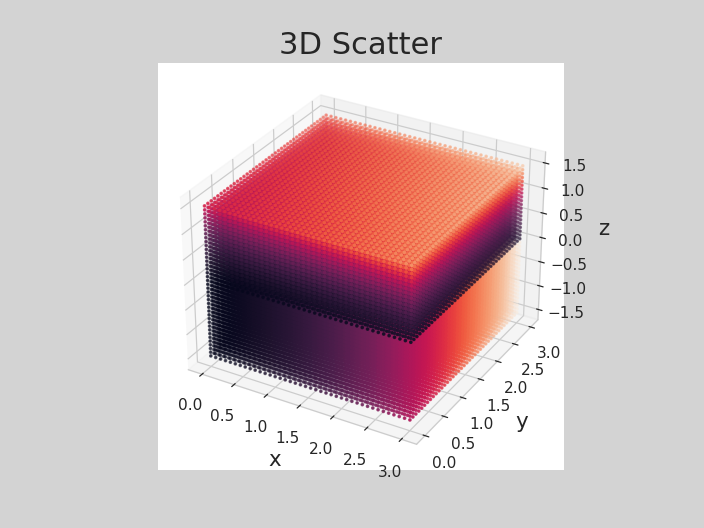

1600


In [89]:
%reset -f
%clear
import numpy as np
import copy
import matplotlib.pyplot as plt 
plt.close('all')
import scipy.io as scio
from mpl_toolkits.mplot3d import axes3d
import pandas as pd
import scipy.stats as stats
import math
from numba import jit # Accelerator
from scipy.spatial import Voronoi, ConvexHull
from sklearn.neighbors import KDTree, KernelDensity
from sklearn.model_selection import GridSearchCV
import platform
import time
import gc
import seaborn as sns

DataX = scio.loadmat('PositionX_3D.mat')
DataX = DataX['N1']
DataY = scio.loadmat('PositionY_3D.mat')
DataY = DataY['N2']
DataZ = scio.loadmat('PositionZ_3D.mat')
DataZ = DataZ['N3']
DataF = scio.loadmat('Data_3D.mat')
DataF = DataF['DataOut']

# DataX = scio.loadmat('PollutedPositionX_3D.mat')
# DataX = DataX['PositionXP']
# DataY = scio.loadmat('PollutedPositionY_3D.mat')
# DataY = DataY['PositionYP']
# DataZ = scio.loadmat('PollutedPositionZ_3D.mat')
# DataZ = DataZ['PositionZP']
# DataF = scio.loadmat('PollutedData_3D.mat')
# DataF = DataF['DataOutP']

%matplotlib notebook
plt.figure("3D Scatter", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('3D Scatter', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)

ax3d.scatter(DataX, DataY, DataZ, c = DataF,s = 2)
plt.show()

NoPs = 40 * 40 # Points in one outend surface
print(NoPs)

# Import data and draw.

## Boundary reflection

<IPython.core.display.Javascript object>


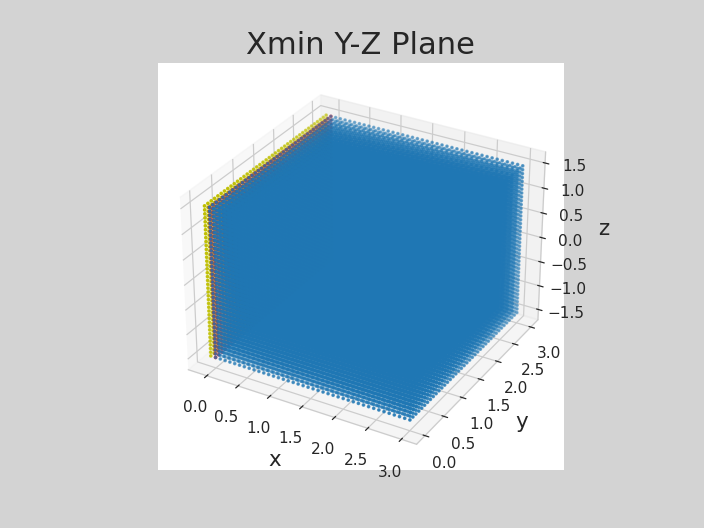

65600


<IPython.core.display.Javascript object>


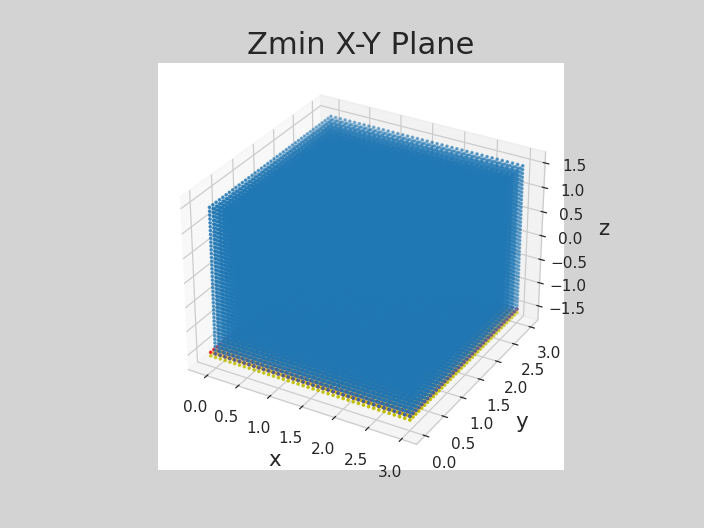

67240


<IPython.core.display.Javascript object>


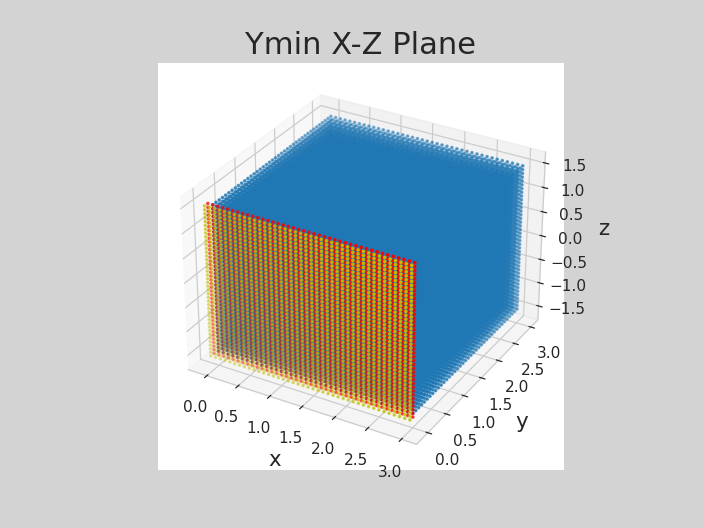

68921


<IPython.core.display.Javascript object>


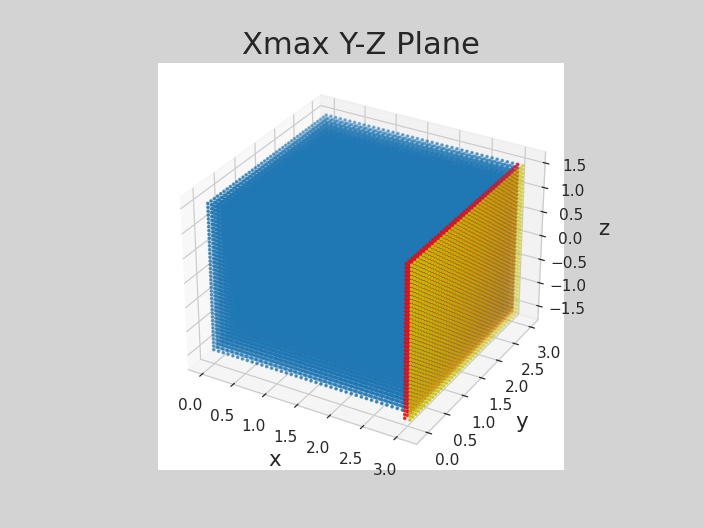

70602


<IPython.core.display.Javascript object>


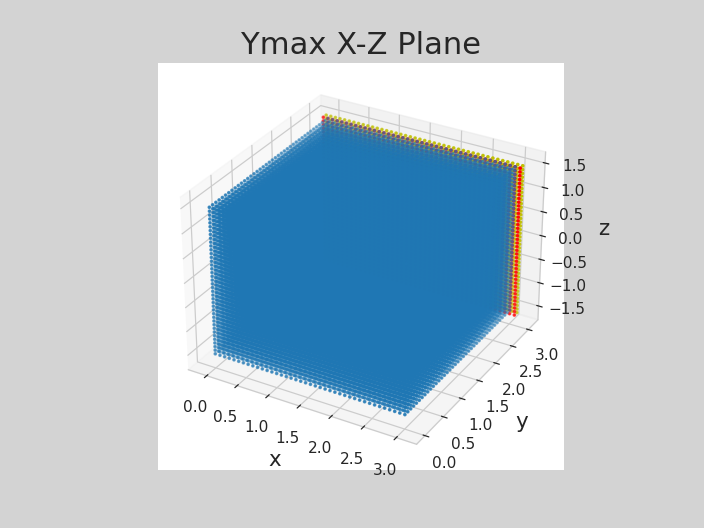

72324


<IPython.core.display.Javascript object>


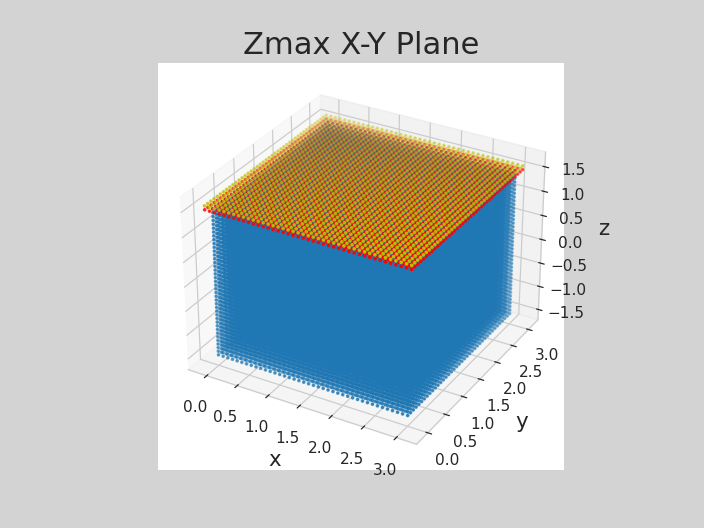

74088


<IPython.core.display.Javascript object>


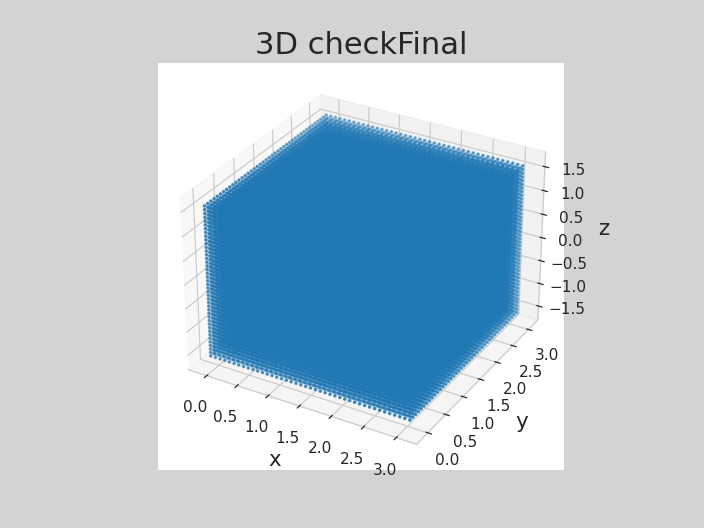

<IPython.core.display.Javascript object>


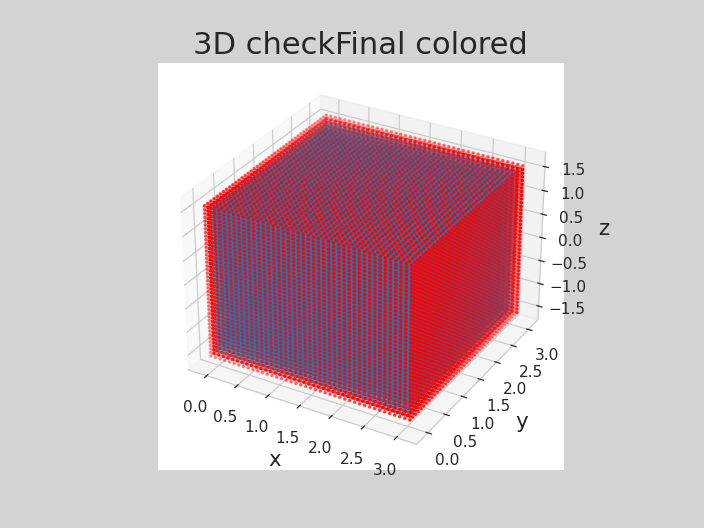

74089


In [90]:
# Temporary parameter for boundary reflection
X_mid = (max(DataX) - min(DataX))/2 + min(DataX)
Y_mid = (max(DataY) - min(DataY))/2 + min(DataY)
Z_mid = (max(DataZ) - min(DataZ))/2 + min(DataZ)

#Xmin Y-Z plane
DataX_Xmin_Ori = copy.deepcopy(DataX)
DataY_Xmin_Ori = copy.deepcopy(DataY)
DataZ_Xmin_Ori = copy.deepcopy(DataZ)
DataF_Xmin_Ori = copy.deepcopy(DataF)

XMinx_Frame = np.zeros((NoPs,1))
XMiny_Frame = np.zeros((NoPs,1))
XMinz_Frame = np.zeros((NoPs,1))
XMinx_M1 = np.zeros((NoPs,1))
XMiny_M1 = np.zeros((NoPs,1))
XMinz_M1 = np.zeros((NoPs,1))

#Frame - The reference line
for PtN in range(NoPs):
    PT_temp = DataX_Xmin_Ori.argmin()
    XMinx_Frame[PtN] = DataX_Xmin_Ori[PT_temp]
    XMiny_Frame[PtN] = DataY_Xmin_Ori[PT_temp]
    XMinz_Frame[PtN] = DataZ_Xmin_Ori[PT_temp]

    DataX_Xmin_Ori[PT_temp] = X_mid
    DataY_Xmin_Ori[PT_temp] = Y_mid
    DataZ_Xmin_Ori[PT_temp] = Z_mid

# M1 & M1m Line 
for PtN in range(NoPs):
    PT_temp = DataX_Xmin_Ori.argmin()
    XMinx_M1[PtN] = DataX_Xmin_Ori[PT_temp]
    XMiny_M1[PtN] = DataY_Xmin_Ori[PT_temp]
    XMinz_M1[PtN] = DataZ_Xmin_Ori[PT_temp]

# Cutting Reflection
XMinx_FrameR = -1 * XMinx_Frame
Xmin_Offset = np.abs(np.mean(XMinx_Frame - XMinx_M1))
Xmin_GAP = np.abs(np.mean(XMinx_Frame - XMinx_FrameR))
XMinx_CR = XMinx_FrameR + Xmin_GAP - Xmin_Offset 

DataX_xmin_DONE = np.vstack((DataX, XMinx_CR))
DataY_xmin_DONE = np.vstack((DataY, XMiny_Frame))
DataZ_xmin_DONE = np.vstack((DataZ, XMinz_Frame))

plt.figure("Xmin Y-Z Plane", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('Xmin Y-Z Plane', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)

ax3d.scatter(DataX, DataY, DataZ, s = 2)
ax3d.scatter(XMinx_Frame, XMiny_Frame, XMinz_Frame, s = 2, c = 'r')
ax3d.scatter(XMinx_CR, XMiny_Frame, XMinz_Frame, s = 2, c = 'y')

plt.show()

print(len(DataX_xmin_DONE))

# Left boundary reflection 
# Yellow reflected points, Red Reference points

#Zmin X-Y plane
NoPs = 1640
DataX_Zmin_Ori = copy.deepcopy(DataX_xmin_DONE)
DataY_Zmin_Ori = copy.deepcopy(DataY_xmin_DONE)
DataZ_Zmin_Ori = copy.deepcopy(DataZ_xmin_DONE)

ZMinx_Frame = np.zeros((NoPs,1))
ZMiny_Frame = np.zeros((NoPs,1))
ZMinz_Frame = np.zeros((NoPs,1))
ZMinx_M1 = np.zeros((NoPs,1))
ZMiny_M1 = np.zeros((NoPs,1))
ZMinz_M1 = np.zeros((NoPs,1))

#Frame - The reference line
for PtN in range(NoPs):
    PT_temp = DataZ_Zmin_Ori.argmin()
    ZMinx_Frame[PtN] = DataX_Zmin_Ori[PT_temp]
    ZMiny_Frame[PtN] = DataY_Zmin_Ori[PT_temp]
    ZMinz_Frame[PtN] = DataZ_Zmin_Ori[PT_temp]

    DataX_Zmin_Ori[PT_temp] = X_mid
    DataY_Zmin_Ori[PT_temp] = Y_mid
    DataZ_Zmin_Ori[PT_temp] = Z_mid


# M1 & M1m Line 
for PtN in range(NoPs):
    PT_temp = DataZ_Zmin_Ori.argmin()
    ZMinx_M1[PtN] = DataX_Zmin_Ori[PT_temp]
    ZMiny_M1[PtN] = DataY_Zmin_Ori[PT_temp]
    ZMinz_M1[PtN] = DataZ_Zmin_Ori[PT_temp]

# Cutting Reflection
ZMinz_FrameR = -1 * ZMinz_Frame
Zmin_Offset = np.abs(np.mean(ZMinz_Frame - ZMinz_M1))
Zmin_GAP = np.abs(np.mean(ZMinz_Frame - ZMinz_FrameR))
ZMinz_CR = ZMinz_FrameR - Zmin_GAP - Zmin_Offset

DataX_Zmin_DONE = np.vstack((DataX_xmin_DONE, ZMinx_Frame))
DataY_Zmin_DONE = np.vstack((DataY_xmin_DONE, ZMiny_Frame))
DataZ_Zmin_DONE = np.vstack((DataZ_xmin_DONE, ZMinz_CR))

plt.figure("Zmin X-Y Plane", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('Zmin X-Y Plane', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)

ax3d.scatter(DataX, DataY, DataZ, s = 2)
ax3d.scatter(ZMinx_Frame, ZMiny_Frame, ZMinz_Frame, s = 2, c = 'r')
ax3d.scatter(ZMinx_Frame, ZMiny_Frame, ZMinz_CR, s = 2, c = 'y')

plt.show()

print(len(DataX_Zmin_DONE))

# Left boundary reflection 
# Yellow reflected points, Red Reference points

#Ymin X-Z plane
NoPs = 1681
DataX_Ymin_Ori = copy.deepcopy(DataX_Zmin_DONE)
DataY_Ymin_Ori = copy.deepcopy(DataY_Zmin_DONE)
DataZ_Ymin_Ori = copy.deepcopy(DataZ_Zmin_DONE)

YMinx_Frame = np.zeros((NoPs,1))
YMiny_Frame = np.zeros((NoPs,1))
YMinz_Frame = np.zeros((NoPs,1))
YMinx_M1 = np.zeros((NoPs,1))
YMiny_M1 = np.zeros((NoPs,1))
YMinz_M1 = np.zeros((NoPs,1))

#Frame - The reference line
for PtN in range(NoPs):
    PT_temp = DataY_Ymin_Ori.argmin()
    YMinx_Frame[PtN] = DataX_Ymin_Ori[PT_temp]
    YMiny_Frame[PtN] = DataY_Ymin_Ori[PT_temp]
    YMinz_Frame[PtN] = DataZ_Ymin_Ori[PT_temp]

    DataX_Ymin_Ori[PT_temp] = X_mid
    DataY_Ymin_Ori[PT_temp] = Y_mid
    DataZ_Ymin_Ori[PT_temp] = Z_mid

# M1 & M1m Line 
for PtN in range(NoPs):
    PT_temp = DataY_Ymin_Ori.argmin()
    YMinx_M1[PtN] = DataX_Ymin_Ori[PT_temp]
    YMiny_M1[PtN] = DataY_Ymin_Ori[PT_temp]
    YMinz_M1[PtN] = DataZ_Ymin_Ori[PT_temp]

# Cutting Reflection
YMiny_FrameR = -1 * YMiny_Frame
Ymin_Offset = np.abs(np.mean(YMiny_Frame - YMiny_M1))
Ymin_GAP = np.abs(np.mean(YMiny_Frame - YMiny_FrameR))
YMiny_CR = YMiny_FrameR + Ymin_GAP - Ymin_Offset

DataX_Ymin_DONE = np.vstack((DataX_Zmin_DONE, YMinx_Frame))
DataY_Ymin_DONE = np.vstack((DataY_Zmin_DONE, YMiny_CR))
DataZ_Ymin_DONE = np.vstack((DataZ_Zmin_DONE, YMinz_Frame))

plt.figure("Ymin X-Z Plane", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('Ymin X-Z Plane', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)

ax3d.scatter(DataX, DataY, DataZ, s = 2)
ax3d.scatter(YMinx_Frame, YMiny_Frame, YMinz_Frame, s = 2, c = 'r')
ax3d.scatter(YMinx_Frame, YMiny_CR, YMinz_Frame, s = 2, c = 'y')

plt.show()

print(len(DataX_Ymin_DONE))

# Left boundary reflection 
# Yellow reflected points, Red Reference points

#Xmax Y-Z plane
NoPs = 1681
DataX_Xmax_Ori = copy.deepcopy(DataX_Ymin_DONE)
DataY_Xmax_Ori = copy.deepcopy(DataY_Ymin_DONE)
DataZ_Xmax_Ori = copy.deepcopy(DataZ_Ymin_DONE)

XMaxx_Frame = np.zeros((NoPs,1))
XMaxy_Frame = np.zeros((NoPs,1))
XMaxz_Frame = np.zeros((NoPs,1))
XMaxx_M1 = np.zeros((NoPs,1))
XMaxy_M1 = np.zeros((NoPs,1))
XMaxz_M1 = np.zeros((NoPs,1))

#Frame - The reference line
for PtN in range(NoPs):
    PT_temp = DataX_Xmax_Ori.argmax()
    XMaxx_Frame[PtN] = DataX_Xmax_Ori[PT_temp]
    XMaxy_Frame[PtN] = DataY_Xmax_Ori[PT_temp]
    XMaxz_Frame[PtN] = DataZ_Xmax_Ori[PT_temp]

    DataX_Xmax_Ori[PT_temp] = X_mid
    DataY_Xmax_Ori[PT_temp] = Y_mid
    DataZ_Xmax_Ori[PT_temp] = Z_mid


# M1 & M1m Line 
for PtN in range(NoPs):
    PT_temp = DataX_Xmax_Ori.argmax()
    XMaxx_M1[PtN] = DataX_Xmax_Ori[PT_temp]
    XMaxy_M1[PtN] = DataY_Xmax_Ori[PT_temp]
    XMaxz_M1[PtN] = DataZ_Xmax_Ori[PT_temp]

# Cutting Reflection
XMaxx_FrameR = -1 * XMaxx_Frame
Xmax_Offset = np.abs(np.mean(XMaxx_Frame - XMaxx_M1))
Xmax_GAP = np.abs(np.mean(XMaxx_Frame - XMaxx_FrameR))
XMaxx_CR = XMaxx_FrameR + Xmax_GAP + Xmax_Offset

DataX_Xmax_DONE = np.vstack((DataX_Ymin_DONE, XMaxx_CR))
DataY_Xmax_DONE = np.vstack((DataY_Ymin_DONE, XMaxy_Frame))
DataZ_Xmax_DONE = np.vstack((DataZ_Ymin_DONE, XMaxz_Frame))

plt.figure("Xmax Y-Z Plane", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('Xmax Y-Z Plane', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)

ax3d.scatter(DataX, DataY, DataZ, s = 2)
ax3d.scatter(XMaxx_Frame, XMaxy_Frame, XMaxz_Frame, s = 2, c = 'r')
ax3d.scatter(XMaxx_CR, XMaxy_Frame, XMaxz_Frame, s = 2, c = 'y')
plt.show()

print(len(DataX_Xmax_DONE))

# Left boundary reflection 
# Yellow reflected points, Red Reference points

#Ymax X-Z plane
NoPs = 1722
DataX_Ymax_Ori = copy.deepcopy(DataX_Xmax_DONE)
DataY_Ymax_Ori = copy.deepcopy(DataY_Xmax_DONE)
DataZ_Ymax_Ori = copy.deepcopy(DataZ_Xmax_DONE)

YMaxx_Frame = np.zeros((NoPs,1))
YMaxy_Frame = np.zeros((NoPs,1))
YMaxz_Frame = np.zeros((NoPs,1))
YMaxx_M1 = np.zeros((NoPs,1))
YMaxy_M1 = np.zeros((NoPs,1))
YMaxz_M1 = np.zeros((NoPs,1))

#Frame - The reference line
for PtN in range(NoPs):
    PT_temp = DataY_Ymax_Ori.argmax()
    YMaxx_Frame[PtN] = DataX_Ymax_Ori[PT_temp]
    YMaxy_Frame[PtN] = DataY_Ymax_Ori[PT_temp]
    YMaxz_Frame[PtN] = DataZ_Ymax_Ori[PT_temp]

    DataX_Ymax_Ori[PT_temp] = X_mid
    DataY_Ymax_Ori[PT_temp] = Y_mid
    DataZ_Ymax_Ori[PT_temp] = Z_mid


# M1 & M1m Line 
for PtN in range(NoPs):
    PT_temp = DataY_Ymax_Ori.argmax()
    YMaxx_M1[PtN] = DataX_Ymax_Ori[PT_temp]
    YMaxy_M1[PtN] = DataY_Ymax_Ori[PT_temp]
    YMaxz_M1[PtN] = DataZ_Ymax_Ori[PT_temp]

# Cutting Reflection
YMaxy_FrameR = -1 * YMaxy_Frame
Ymax_Offset = np.abs(np.mean(YMaxy_Frame - YMaxy_M1))
Ymax_GAP = np.abs(np.mean(YMaxy_Frame - YMaxy_FrameR))
YMaxy_CR = YMaxy_FrameR + Ymax_GAP + Ymax_Offset

DataX_Ymax_DONE = np.vstack((DataX_Xmax_DONE, YMaxx_Frame))
DataY_Ymax_DONE = np.vstack((DataY_Xmax_DONE, YMaxy_CR))
DataZ_Ymax_DONE = np.vstack((DataZ_Xmax_DONE, YMaxz_Frame))

plt.figure("Ymax X-Z Plane", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('Ymax X-Z Plane', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)

ax3d.scatter(DataX, DataY, DataZ, s = 2)
ax3d.scatter(YMaxx_Frame, YMaxy_Frame, YMaxz_Frame, s = 2, c = 'r')
ax3d.scatter(YMaxx_Frame, YMaxy_CR, YMaxz_Frame, s = 2, c = 'y')

plt.show()

print(len(DataY_Ymax_DONE))

# Left boundary reflection 
# Yellow reflected points, Red Reference points

#Zmax X-Y plane
NoPs = 1764
DataX_Zmax_Ori = copy.deepcopy(DataX_Ymax_DONE)
DataY_Zmax_Ori = copy.deepcopy(DataY_Ymax_DONE)
DataZ_Zmax_Ori = copy.deepcopy(DataZ_Ymax_DONE)

ZMaxx_Frame = np.zeros((NoPs,1))
ZMaxy_Frame = np.zeros((NoPs,1))
ZMaxz_Frame = np.zeros((NoPs,1))
ZMaxx_M1 = np.zeros((NoPs,1))
ZMaxy_M1 = np.zeros((NoPs,1))
ZMaxz_M1 = np.zeros((NoPs,1))

#Frame - The reference line
for PtN in range(NoPs):
    PT_temp = DataZ_Zmax_Ori.argmax()
    ZMaxx_Frame[PtN] = DataX_Zmax_Ori[PT_temp]
    ZMaxy_Frame[PtN] = DataY_Zmax_Ori[PT_temp]
    ZMaxz_Frame[PtN] = DataZ_Zmax_Ori[PT_temp]

    DataX_Zmax_Ori[PT_temp] = X_mid
    DataY_Zmax_Ori[PT_temp] = Y_mid
    DataZ_Zmax_Ori[PT_temp] = Z_mid

# M1 & M1m Line 
for PtN in range(NoPs):
    PT_temp = DataZ_Zmax_Ori.argmax()
    ZMaxx_M1[PtN] = DataX_Zmax_Ori[PT_temp]
    ZMaxy_M1[PtN] = DataY_Zmax_Ori[PT_temp]
    ZMaxz_M1[PtN] = DataZ_Zmax_Ori[PT_temp]

# Cutting Reflection
ZMaxz_FrameR = -1 * ZMaxz_Frame
Zmax_Offset = np.abs(np.mean(ZMaxz_Frame - ZMaxz_M1))
Zmax_GAP = np.abs(np.mean(ZMaxz_Frame - ZMaxz_FrameR))
ZMaxz_CR = ZMaxz_FrameR + Zmax_GAP + Zmax_Offset

DataX_Zmax_DONE = np.vstack((DataX_Ymax_DONE, ZMaxx_Frame))
DataY_Zmax_DONE = np.vstack((DataY_Ymax_DONE, ZMaxy_Frame))
DataZ_Zmax_DONE = np.vstack((DataZ_Ymax_DONE, ZMaxz_CR))

plt.figure("Zmax X-Y Plane", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('Zmax X-Y Plane', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)

ax3d.scatter(DataX, DataY, DataZ, s = 2)
ax3d.scatter(ZMaxx_Frame, ZMaxy_Frame, ZMaxz_Frame, s = 2, c = 'r')
ax3d.scatter(ZMaxx_Frame, ZMaxy_Frame, ZMaxz_CR, s = 2, c = 'y')

plt.show()

print(len(DataX_Zmax_DONE))

# Left boundary reflection 
# Yellow reflected points, Red Reference points

# Show points cloud and reflected boundary
Data3D_x = copy.deepcopy(DataX_Zmax_DONE)
Data3D_y = copy.deepcopy(DataY_Zmax_DONE)
Data3D_z = copy.deepcopy(DataZ_Zmax_DONE)
Data3D = np.hstack((Data3D_x, Data3D_y, Data3D_z))
type(Data3D)

vor = Voronoi(Data3D)
vor_vertices = copy.deepcopy(vor.vertices)
vor_regions = copy.deepcopy(vor.regions)

# The crude votonoi cell, the boundary was tend to infinity

plt.figure("3D checkFinal", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('3D checkFinal', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)
ax3d.scatter(Data3D_x, Data3D_y, Data3D_z, s = 2)

plt.show()

plt.figure("3D checkFinal colored", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('3D checkFinal colored', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)
ax3d.scatter(DataX, DataY, DataZ, s = 2)
ax3d.scatter(XMaxx_CR, XMaxy_Frame, XMaxz_Frame, s = 2, c = 'r')
ax3d.scatter(YMaxx_Frame, YMaxy_CR, YMaxz_Frame, s = 2, c = 'r')
ax3d.scatter(ZMaxx_Frame, ZMaxy_Frame, ZMaxz_CR, s = 2, c = 'r')
ax3d.scatter(XMinx_CR, XMiny_Frame, XMinz_Frame, s = 2, c = 'r')
ax3d.scatter(YMinx_Frame, YMiny_CR, YMinz_Frame, s = 2, c = 'r')
ax3d.scatter(ZMinx_Frame, ZMiny_Frame, ZMinz_CR, s = 2, c = 'r')

plt.show()

OriginNoCell = len(vor_regions)
print(len(vor_regions))

## Engage Voronoi cell  

Import voronoi cell package to determine the inflence area for each data point. The peckage is so crude that we need apply another boundary treatment afterward.

In [92]:
NoVoronoiCell = len(vor.regions)
V_vertices_x = copy.deepcopy(vor.vertices[:, 0])
V_vertices_y = copy.deepcopy(vor.vertices[:, 1])
V_vertices_z = copy.deepcopy(vor.vertices[:, 2])

V_coord_x = [ [] for _ in range(NoVoronoiCell) ]
V_coord_y = [ [] for _ in range(NoVoronoiCell) ]
V_coord_z = [ [] for _ in range(NoVoronoiCell) ]

#Triming threshold
XMax = np.max(XMaxx_CR - 0.3 * Xmax_Offset)
YMax = np.max(YMaxy_CR - 0.3 * Ymax_Offset)
ZMax = np.max(ZMaxz_CR - 0.3 * Zmax_Offset)
XMin = np.max(XMinx_CR - 0.3 * Xmin_Offset)
YMin = np.max(YMiny_CR - 0.3 * Ymin_Offset)
ZMin = np.max(ZMinz_CR - 0.3 * Zmax_Offset)

print('Threshold in x: ', round(XMax, 2), round(XMin, 2), \
      '\nThreshold in y: ', round(YMax, 2), round(YMin, 2), \
     '\nThreshold in z: ', round(ZMax, 2), round(ZMin, 2))

NoPs = 42
XGrid_ST = (XMax - XMin)/NoPs
YGrid_ST = (YMax - YMin)/NoPs
ZGrid_ST = (ZMax - ZMin)/NoPs
print('\nStandard grid size should be without noisy perturbation in x, y, z:\n',\
      round(XGrid_ST, 2), round(YGrid_ST, 2), round(ZGrid_ST, 2))

Threshold in x:  3.05 -0.1 
Threshold in y:  3.05 -0.1 
Threshold in z:  1.55 -1.6

Standard grid size should be without noisy perturbation in x, y, z:
 0.08 0.08 0.08


## Trimming Voronoi cell
The rige of our data field out of our boundary even tend to infinity, when 
apply the packed voronoi cell generation algorithm. Though, by now we got to trim off the 
exceeded points and make sure the polygon keep convex.

In [93]:
# Delete the exceed points which behind or wothin 'The frame' in 
# section 1.2 boundary secure
VEmptyCount = 0
Cell_STD_x = np.zeros(NoVoronoiCell)
Cell_STD_y = np.zeros(NoVoronoiCell)
Cell_STD_z = np.zeros(NoVoronoiCell)

for i in range(NoVoronoiCell):

    DeleteHint = 0;
    VL_Temp = len(vor.regions[i])

    if VL_Temp == 0:
        continue
        
    V_coord_x[i] = np.zeros(VL_Temp)
    V_coord_y[i] = np.zeros(VL_Temp)
    V_coord_z[i] = np.zeros(VL_Temp)
    Ori_Check_x = np.zeros(VL_Temp)
    Ori_Check_y = np.zeros(VL_Temp)
    Ori_Check_z = np.zeros(VL_Temp)
    
    for j in range(VL_Temp):
        NoC = vor.regions[i][j]
        V_coord_x[i][j] = V_vertices_x[NoC]
        V_coord_y[i][j] = V_vertices_y[NoC]
        V_coord_z[i][j] = V_vertices_z[NoC]
        Ori_Check_x[j] = V_vertices_x[NoC]
        Ori_Check_y[j] = V_vertices_y[NoC]
        Ori_Check_z[j] = V_vertices_z[NoC]
        
        if V_coord_x[i][j] < XMin:

            V_coord_x[i] = []
            V_coord_y[i] = []
            V_coord_z[i] = []
            VEmptyCount = VEmptyCount + 1
            DeleteHint = 1
            break
        elif V_coord_x[i][j] > XMax:
            V_coord_x[i] = []
            V_coord_y[i] = []
            V_coord_z[i] = []
            VEmptyCount = VEmptyCount + 1
            DeleteHint = 1
            break
        elif V_coord_y[i][j] > YMax: 
            V_coord_x[i] = []
            V_coord_y[i] = []
            V_coord_z[i] = []
            VEmptyCount = VEmptyCount + 1
            DeleteHint = 1
            break
        elif V_coord_y[i][j] < YMin:
            V_coord_x[i] = []
            V_coord_y[i] = []
            V_coord_z[i] = []
            VEmptyCount = VEmptyCount + 1
            DeleteHint = 1
            break
        elif V_coord_z[i][j] > ZMax: 
            V_coord_x[i] = []
            V_coord_y[i] = []
            V_coord_z[i] = []
            VEmptyCount = VEmptyCount + 1
            DeleteHint = 1
            break
        elif V_coord_z[i][j] < ZMin:
            V_coord_x[i] = []
            V_coord_y[i] = []
            V_coord_z[i] = []
            VEmptyCount = VEmptyCount + 1
            DeleteHint = 1
            break
        
    Cell_STD_x[i] = np.std(V_coord_x[i])
    Cell_STD_y[i] = np.std(V_coord_y[i])
    Cell_STD_z[i] = np.std(V_coord_z[i])
    # Prevent detection fail in small noisy
    if Cell_STD_x[i] > XGrid_ST * 0.6:
        V_coord_x[i] = []
        V_coord_y[i] = []
        V_coord_z[i] = []
        Cell_STD_x[i] = 0
        VEmptyCount = VEmptyCount + 1
        DeleteHint = 1
#         print('XG')
    elif Cell_STD_y[i] > YGrid_ST * 0.6:
        V_coord_x[i] = []
        V_coord_y[i] = []
        V_coord_z[i] = []
        Cell_STD_y[i] = 0
        VEmptyCount = VEmptyCount + 1
        DeleteHint = 1
#         print('YG')
    elif Cell_STD_z[i] > ZGrid_ST * 0.6:
        V_coord_x[i] = []
        V_coord_y[i] = []
        V_coord_z[i] = []
        Cell_STD_z[i] = 0
        VEmptyCount = VEmptyCount + 1
        DeleteHint = 1
#         print('ZG')

    if DeleteHint == 0:                
        V_coord_x[i] = np.append(V_coord_x[i], V_coord_x[i][0])
        V_coord_y[i] = np.append(V_coord_y[i], V_coord_y[i][0])
        V_coord_z[i] = np.append(V_coord_z[i], V_coord_z[i][0])

    
#     print('Voronoi cell increment x', Cell_STD_x[i])
#     print('Standard grid x increment', XGrid_ST)
#     print('Voronoi cell increment y', Cell_STD_y[i])
#     print('Standard grid y increment', YGrid_ST)
#     print('Voronoi cell increment z', Cell_STD_z[i])
#     print('Standard grid z increment', ZGrid_ST)

print('Number of cell out of boundary which treated as empty: \n', VEmptyCount)

NewNoPCell = len(V_coord_x)
print('\n The total number of cell: \n', NewNoPCell)

Number of cell out of boundary which treated as empty: 
 10088

 The total number of cell: 
 74089


<IPython.core.display.Javascript object>


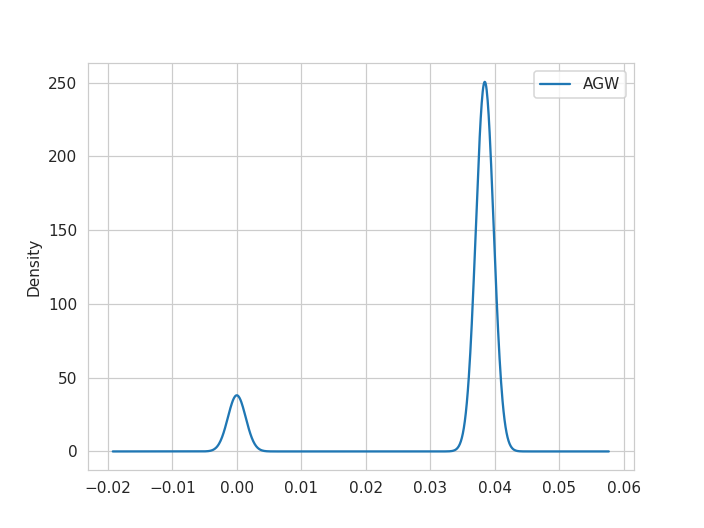

<IPython.core.display.Javascript object>


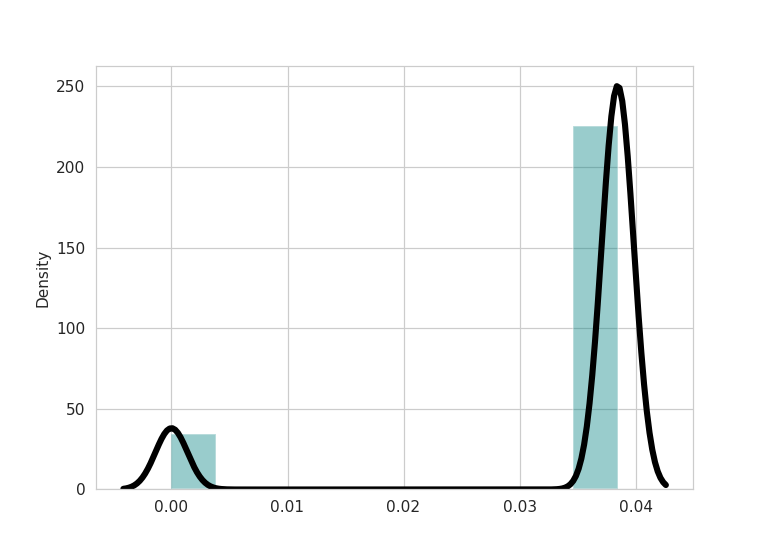

/tmp/ipykernel_5944/57661355.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x = df["AGW"]   ,  bins = 10 , kde = True , color = 'teal'


In [94]:
x = Cell_STD_x  #Generating Data
source = {"Genotype": ["CV1"] * NewNoPCell, "AGW": x}
df=pd.DataFrame(source) #Converting to pandas DataFrame
df.plot(kind = 'density'); # or df["AGW"].plot(kind = 'density');

sns.set_style("whitegrid")  # Setting style(Optional)
plt.figure(figsize = (7,5)) #Specify the size of figure
sns.distplot(x = df["AGW"]   ,  bins = 10 , kde = True , color = 'teal'
            , kde_kws=dict(linewidth = 4 , color = 'black')) #kde for normal distribution
plt.show()

In [95]:
NewIndex = 0
NewV_coord_x = list()
NewV_coord_y = list()
NewV_coord_z = list()

for NoC in range(len(vor.regions)):
    if len(V_coord_x[NoC]) == 0:
        continue
    elif len(V_coord_x[NoC]) != 0 and NewIndex == 0:
        NewV_coord_x.append(V_coord_x[NoC])
        NewV_coord_y.append(V_coord_y[NoC])
        NewV_coord_z.append(V_coord_z[NoC])
        NewIndex = NewIndex + 1
    else:
        NewV_coord_x.append(V_coord_x[NoC])
        NewV_coord_y.append(V_coord_y[NoC])
        NewV_coord_z.append(V_coord_z[NoC])
        NewIndex = NewIndex + 1

print(NewIndex)

64000


<IPython.core.display.Javascript object>


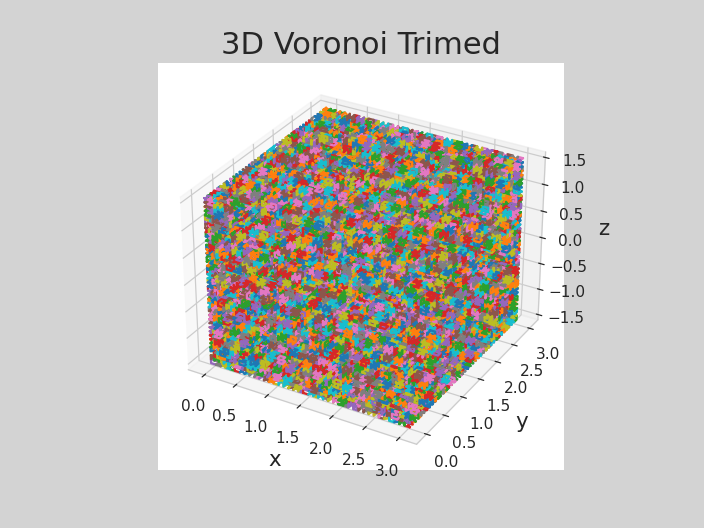

In [96]:
plt.figure("3D Voronoi Trimed", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('3D Voronoi Trimed', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)
for i in range(NewIndex): 
    ax3d.plot(NewV_coord_x[i], NewV_coord_y[i], NewV_coord_z[i])

plt.show()

In [97]:
VolVoeSubj = np.zeros(NewIndex)
VolVoeObjec = np.zeros(NewIndex)

for i in range(NewIndex):
    CellL = len(NewV_coord_y[i])
    xxx = np.zeros((CellL, 3))
    for j in range(CellL):
        
        xxx[j][0] = NewV_coord_x[i][j]
        xxx[j][1] = NewV_coord_y[i][j]
        xxx[j][2] = NewV_coord_z[i][j]

    vvvv = ConvexHull(xxx)
    VolVoeSubj[i] = vvvv.volume
# StandardV = np.mean(VolVoeSubj)

# for i in range(NewIndex):
#     VolVoeObjec[i] = VolVoeSubj[i] / StandardV

    
print(np.sum(VolVoeSubj))
print(len(VolVoeSubj))
# print(StandardV)
# print(np.mean(VolVoeObjec))
print(max(VolVoeSubj))

29.130632680928535
64000
0.00045516613563951634


<IPython.core.display.Javascript object>


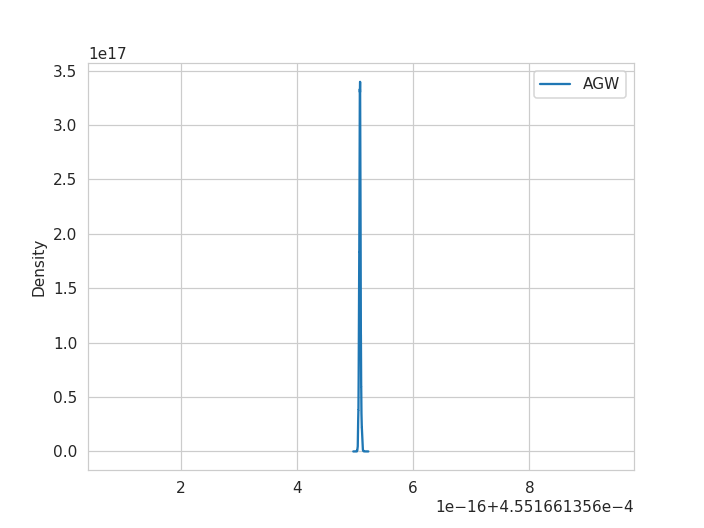

<IPython.core.display.Javascript object>


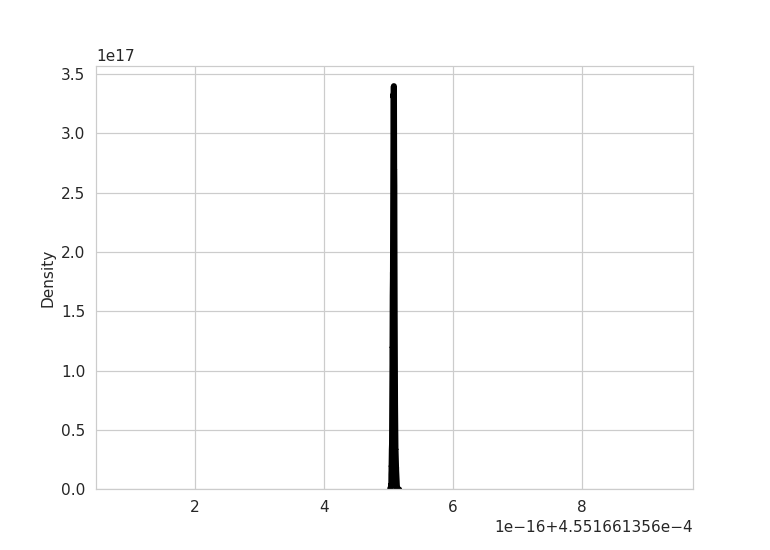

/tmp/ipykernel_5944/1389069097.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x = df["AGW"]   ,  bins = 10 , kde = True , color = 'teal'


In [98]:
x = VolVoeSubj  #Generating Data
source = {"Genotype": ["CV1"] * len(x), "AGW": x}
df=pd.DataFrame(source) #Converting to pandas DataFrame
df.plot(kind = 'density'); # or df["AGW"].plot(kind = 'density');

sns.set_style("whitegrid")  # Setting style(Optional)
plt.figure(figsize = (7,5)) #Specify the size of figure
sns.distplot(x = df["AGW"]   ,  bins = 10 , kde = True , color = 'teal'
            , kde_kws=dict(linewidth = 4 , color = 'black')) #kde for normal distribution
plt.show()

In [99]:
Inter_Left_x = 0.3
Inter_Right_x = 2.7
Inter_Left_y = 0.3
Inter_Right_y = 2.7
Inter_Left_z = -1.2
Inter_Right_z = 1.2

n = 30
Inter_Data_x = np.linspace(Inter_Left_x, Inter_Right_x, num = n)
Inter_Data_y = np.linspace(Inter_Left_y, Inter_Right_y, num = n)
Inter_Data_z = np.linspace(Inter_Left_z, Inter_Right_z, num = n)

x_Inter = np.zeros(pow(n, 3))
y_Inter = np.zeros(pow(n, 3))
z_Inter = np.zeros(pow(n, 3))

for xIndex in range(n):
    for yIndex in range(n):
        for zIndex in range(n):
            
            x_Inter[xIndex * n * n + yIndex  * n + zIndex] = \
            Inter_Data_x[xIndex]
            y_Inter[xIndex * n * n + yIndex  * n + zIndex] = \
            Inter_Data_y[yIndex]
            z_Inter[xIndex * n * n + yIndex  * n + zIndex] = \
            Inter_Data_z[zIndex]

x_Inter = np.reshape(x_Inter, (len(x_Inter), 1))
y_Inter = np.reshape(y_Inter, (len(y_Inter), 1))
z_Inter = np.reshape(z_Inter, (len(z_Inter), 1))

In [100]:
T1 = time.perf_counter()

DataSet_3D = np.hstack((DataX, DataY, DataZ))
InterSet_3D = np.hstack((x_Inter, y_Inter, z_Inter))
N_Quiry = len(InterSet_3D)    
N_Data = len(DataSet_3D)
r_0 = 0.1
r_1 = 0.5
rn = 6

print(N_Data)

# tree = KDTree(DataSet_3D)
r_range = np.linspace(r_0, r_1, rn)

def DomainCutoff(DataSet, Interpoints, r_range, rn):
    PoinsInd = []
    distance = []
    
    tree = KDTree(DataSet)
    for i in range(rn):
        PoinsInd_one, distance_one = tree.query_radius(Interpoints, r = r_range[i], \
                                    return_distance=True)
        PoinsInd.append(PoinsInd_one)
        distance.append(distance_one)
    return PoinsInd, distance

PoinsInd, distance = DomainCutoff(DataSet_3D, InterSet_3D, \
                                              r_range, rn)

T2 = time.perf_counter()
print(T2 - T1)

64000
3.074868044000141


In [101]:
Distance_choiced = distance[5]
PoinsIndex_choiced = PoinsInd[5]
IndexL = len(PoinsIndex_choiced[0])
# print(IndexL)
# print(PoinsIndex_choiced[0])
# print(PoinsIndex_choiced[0][0])
# print(DataX[PoinsIndex_choiced[0][0]])

In [103]:
aGau = list(map(lambda x: 1 / (pow(math.pi, 1.5) * pow(x*2, 3)), r_range))
aGau = np.array(aGau)

@jit(nopython=True)
def DistanceAll(distance, PoinsIndNP, VolVoeSubj, aGau, r_range):
                
    W_Gauij = 0
    N_Data = len(distance)
            
    for j in range(N_Data):
        
        
        q = distance[j] / (r_range * 2)
        W_GauN = aGau * math.exp( -1 * math.pow(q, 2))
        W_Gauij = W_Gauij + W_GauN * VolVoeSubj[PoinsIndNP[j]]
        
    return(W_Gauij)

Q_length = len(distance[0])
W_GauN = np.zeros((rn, Q_length))
# W_GauNH = []
# print(W_GauN)
for j in range(rn):
    distanceNP = np.array(distance[j][0:])
    PoinsIndNP = np.array(PoinsInd[j])
    aGauNP = aGau[0]
    r_rangeNP = r_range[0]
    for i in range(Q_length) :
        W_GauN[j, i] = DistanceAll(distanceNP[i], PoinsIndNP[i], VolVoeSubj, \
                                aGauNP, r_rangeNP)
# W_GauNH.append(W_GauN) 
print(W_GauN)


[[0.08692338 0.07095786 0.07093751 ... 0.07093751 0.07095786 0.08692338]
 [0.3441042  0.3663975  0.35285912 ... 0.35285912 0.3663975  0.3441042 ]
 [0.66578852 0.67147781 0.6695788  ... 0.6695788  0.67147781 0.66578852]
 [0.87836923 0.87840832 0.87954948 ... 0.87954948 0.87840832 0.87836923]
 [0.95830266 0.96194446 0.9619518  ... 0.9619518  0.96194446 0.95830266]
 [0.97432482 0.98030984 0.98098599 ... 0.98098599 0.98030984 0.97432482]]


27000
[0.97432482 0.98030984 0.98098599 ... 0.98098599 0.98030984 0.97432482]


<IPython.core.display.Javascript object>


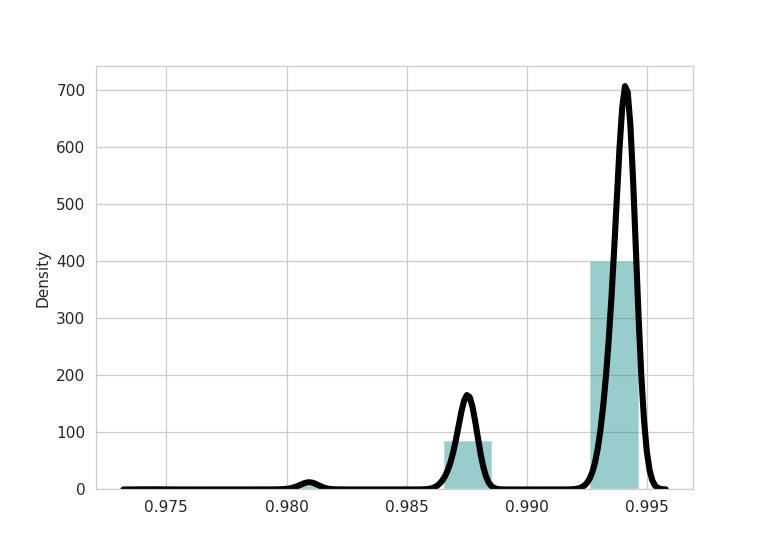

/tmp/ipykernel_5944/2792161905.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x = df["AGW"]   ,  bins = 10 , kde = True , color = 'teal'


In [104]:
print(len(W_GauN[-1, :]))
a = W_GauN[-1, :]
a = a.reshape(1, 27000)
print(a[0])

x = a[0]  #Generating Data
source = {"Genotype": ["CV1"] * len(x), "AGW": x}
df=pd.DataFrame(source) #Converting to pandas DataFrame

sns.set_style("whitegrid")  # Setting style(Optional)
plt.figure(figsize = (7,5)) #Specify the size of figure
sns.distplot(x = df["AGW"]   ,  bins = 10 , kde = True , color = 'teal'
            , kde_kws=dict(linewidth = 4 , color = 'black')) #kde for normal distribution
plt.show()

In [ ]:
import copy
WR_MinMatrix = np.abs(np.abs(copy.deepcopy(W_GauN)) - 1)
WR_Min = np.zeros(N_Quiry)
WR_h_CoordR = np.zeros(N_Quiry)
h_Fix = np.zeros(N_Quiry)
aGau_Fix = np.zeros(N_Quiry)

print(WR_MinMatrix)
print(Q_length)
print(len(h_Fix))

for i in range(N_Quiry):
    WR_Min[i] = WR_MinMatrix[:, i].min()
    WR_h_Coord = np.argmin(WR_MinMatrix[:, i])
    WR_h_Coord = int(WR_h_Coord)
#     print(WR_Min[i])
#     print(type(WR_h_Coord))
#     print(WR_h_Coord)
# #     print(WR_MinMatrix[i, WR_h_Coord])
    WR_h_CoordR[i] = WR_h_Coord
#     print(WR_h_CoordR[i])
    h_Fix[i] = r_range[WR_h_Coord]
    aGau_Fix[i] = aGau[WR_h_Coord]
# print(h_Fix)
# print(aGau_Fix)

In [105]:
print(DataF[0][0])

1.0


In [107]:
W_GauProve = np.zeros((Q_length, 1))

@jit(nopython=True)
def DistanceAllP(distance, PoinsIndNP, VolVoeSubj, aGau, r_range, DataF):
                
    W_Gauij = 0
    N_Data = len(distance)
            
    for j in range(N_Data):
        
        q = distance[j] / (r_range * 2)
        W_GauN = aGau * math.exp( -1 * math.pow(q, 2))
        W_Gauij = W_Gauij + W_GauN * VolVoeSubj[PoinsIndNP[j]] * \
        DataF[PoinsIndNP[j]][0]

    return(W_Gauij)

for i in range(Q_length) :
    W_GauProve[i] = DistanceAllP(distanceNP[i], PoinsIndNP[i], VolVoeSubj, \
                                aGau[0], r_range[0], DataF)

print(W_GauProve)

[[1.19795532]
 [1.20528543]
 [1.20612229]
 ...
 [4.17797843]
 [4.53339644]
 [4.8813562 ]]


In [16]:
print(DataF)

[[1.        ]
 [1.        ]
 [1.        ]
 ...
 [6.02642428]
 [6.50829113]
 [7.02868758]]


In [17]:
print(InterSet_3D[0][0])

0.3


In [108]:
DataXr = DataX.reshape(1, len(DataX))
DataYr = DataY.reshape(1, len(DataY))
DataZr = DataZ.reshape(1, len(DataZ))
r_rangeDouble = r_range * 2

T1 = time.perf_counter()

@jit(nopython=True)
def DistanceAllPD(distance, PoinsIndNP, VolVoeSubj, aGau, r_range, \
                 DataX, DataY, DataZ, Interpoints, DataF, x_Inter, y_Inter, \
                 z_Inter):
                
    W_Gauij = 0
    N_Data = len(distance)
    Gauij_dev_x = 0
    Gauij_dev_y = 0
    Gauij_dev_z = 0
    for j in range(N_Data):
        
        Dx = (x_Inter[0] - DataX[PoinsIndNP[j]]) / distance[j]
        Dy = (y_Inter[0] - DataY[PoinsIndNP[j]]) / distance[j]
        Dz = (z_Inter[0] - DataZ[PoinsIndNP[j]]) / distance[j]

        if Dx is None:
            Dx = 0
        if Dy is None:
            Dy = 0
        if Dz is None:
            Dz = 0
                
        q = distance[j] / r_range

        Gau_dev_x = Dx * aGau * \
            math.exp( -1 * math.pow(q, 2)) * (-2 * distance[j] / \
                                             math.pow(r_range, 2))
        Gauij_dev_x = Gauij_dev_x + \
            Gau_dev_x * VolVoeSubj[PoinsIndNP[j]] * DataF[PoinsIndNP[j]][0]
        
        Gau_dev_y = Dy * aGau * \
            math.exp( -1 * math.pow(q, 2)) * (-2 * distance[j] / \
                                             math.pow(r_range, 2))
        Gauij_dev_y = Gauij_dev_y + \
            Gau_dev_y * VolVoeSubj[PoinsIndNP[j]] * DataF[PoinsIndNP[j]][0]
        
        Gau_dev_z = Dz * aGau * \
            math.exp( -1 * math.pow(q, 2)) * (-2 * distance[j] / \
                                             math.pow(r_range, 2))
        Gauij_dev_z = Gauij_dev_z + \
            Gau_dev_z * VolVoeSubj[PoinsIndNP[j]] * DataF[PoinsIndNP[j]][0]

        W_GauN = aGau * math.exp( -1 * math.pow(q, 2))
        W_Gauij = W_Gauij + W_GauN * VolVoeSubj[PoinsIndNP[j]]
        
    return(W_Gauij, Gauij_dev_x, Gauij_dev_y, Gauij_dev_z)

Q_length = len(distance[0])
W_GauN = np.zeros((Q_length))
Gauij_dev_x = np.zeros((Q_length))
Gauij_dev_y = np.zeros((Q_length))
Gauij_dev_z = np.zeros((Q_length))

for i in range(Q_length) :
    W_GauN[i], Gauij_dev_x[i], Gauij_dev_y[i], Gauij_dev_z[i] = \
    DistanceAllPD(distanceNP[i], PoinsIndNP[i], VolVoeSubj, \
                            aGau[0], r_rangeDouble[0], DataXr[0], DataYr[0], \
                                DataZr[0], InterSet_3D[i], DataF, \
                  x_Inter[i], y_Inter[i], z_Inter[i])
print(W_GauN)

T2 = time.perf_counter()
print(T2 - T1)

[0.97432482 0.98030984 0.98098599 ... 0.98098599 0.98030984 0.97432482]
0.5350565389999247


In [19]:
print(Gauij_dev_x)
print(Gauij_dev_y)
print(Gauij_dev_z)

[ 0.66136167  0.66297554  0.66374648 ... -0.14594208 -0.15825752
 -0.18161987]
[ 0.40779972  0.40807928  0.40875347 ... -0.34109132 -0.37012439
 -0.4100534 ]
[1.55057292e-01 2.08092556e-02 1.33220715e-04 ... 4.09803629e+00
 4.33048464e+00 3.89770231e+00]


In [109]:
Dev_x = copy.deepcopy(Gauij_dev_x.transpose())
Dev_x = np.array(Dev_x)
Dev_y = copy.deepcopy(Gauij_dev_y.transpose())
Dev_y = np.array(Dev_y)
Dev_z = copy.deepcopy(Gauij_dev_z.transpose())
Dev_z = np.array(Dev_z)
print(Dev_x)
print(len(x_Inter))

[ 0.66136167  0.66297554  0.66374648 ... -0.14594208 -0.15825752
 -0.18161987]
27000


<IPython.core.display.Javascript object>


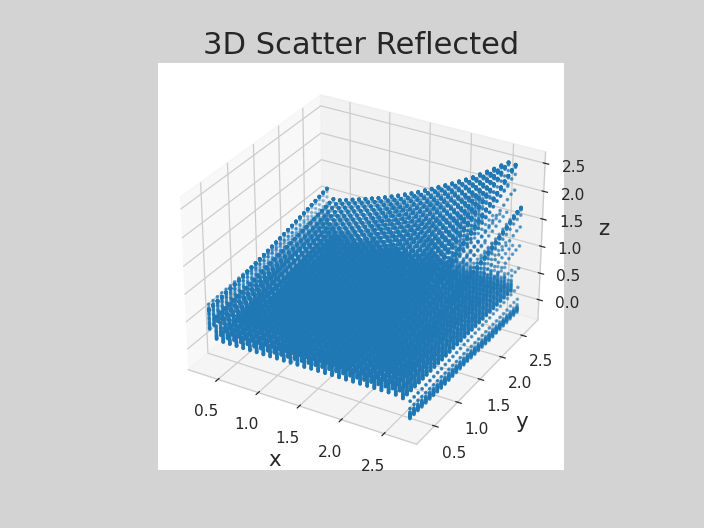

<IPython.core.display.Javascript object>


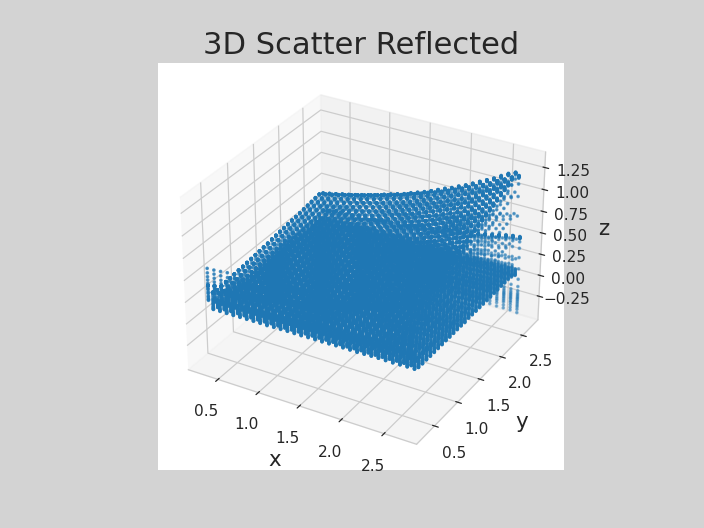

<IPython.core.display.Javascript object>


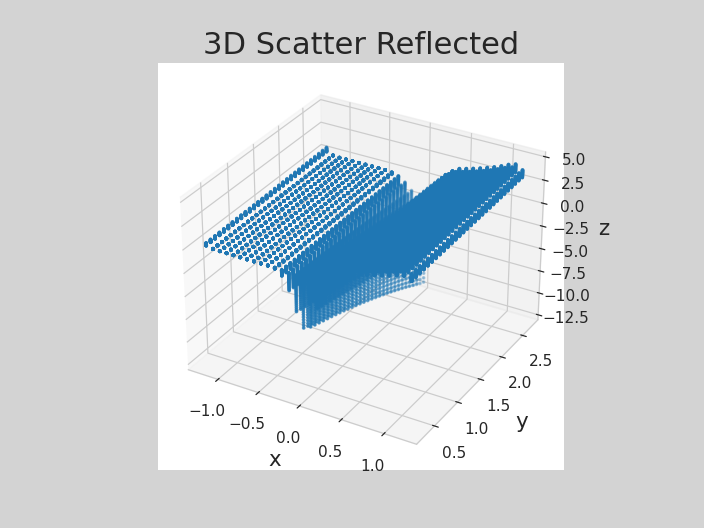

In [110]:
plt.figure("DevX", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('3D Scatter Reflected', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)
ax3d.scatter(x_Inter, y_Inter, Gauij_dev_x, s = 2)
plt.show()

plt.figure("DevY", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('3D Scatter Reflected', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)
ax3d.scatter(x_Inter, y_Inter, Dev_y, s = 2)
plt.show()

plt.figure("DevZ", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('3D Scatter Reflected', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)
ax3d.scatter(z_Inter, y_Inter, Dev_z, s = 2)
plt.show()


In [22]:
print(Gauij_dev_x)
print(Gauij_dev_y)
print(Gauij_dev_z)

[ 0.66136167  0.66297554  0.66374648 ... -0.14594208 -0.15825752
 -0.18161987]
[ 0.40779972  0.40807928  0.40875347 ... -0.34109132 -0.37012439
 -0.4100534 ]
[1.55057292e-01 2.08092556e-02 1.33220715e-04 ... 4.09803629e+00
 4.33048464e+00 3.89770231e+00]


In [111]:
import copy
lenDD = len(Gauij_dev_x)

DD1 = copy.deepcopy(Gauij_dev_x)
DD2 = copy.deepcopy(Gauij_dev_y)
DD3 = copy.deepcopy(Gauij_dev_z)

LastEigenvector = np.zeros((lenDD, 3))
LastEigenvectorABS = np.zeros((lenDD, 3))
for i in range(lenDD):
# for i in range(1):

    pFpi = np.vstack((DD1[i], DD2[i], DD3[i]))
#     print(pFpi)
#     WW = np.outer(pFpi, pFpi.transpose())
    WW = np.dot(pFpi, pFpi.transpose())
#     print(WW)
    Eigenvalues, Eigenvectors = np.linalg.eig(WW)
#     print(Eigenvalues)
#     print(Eigenvectors)
    EigneValue_MaxIndex = Eigenvalues.argmax()
#     print('Max index is: ', EigneValue_MaxIndex)
    vesSwitch = Eigenvectors[EigneValue_MaxIndex, :]
#     print(vesSwitch)
    
    LastEigenvectorABS[i, 0] = abs(vesSwitch[0])
    LastEigenvectorABS[i, 1] = abs(vesSwitch[1])
    LastEigenvectorABS[i, 2] = abs(vesSwitch[2])
#     print(LastEigenvectorABS)
    
EigenFrame = pd.DataFrame({'Ev_x':LastEigenvectorABS[:, 0], \
                           'Ev_y':LastEigenvectorABS[:, 1], \
                          'Ev_z':LastEigenvectorABS[:, 2]})
EigenFrame.to_csv("Ev.csv", index = False, sep = ',')

<IPython.core.display.Javascript object>


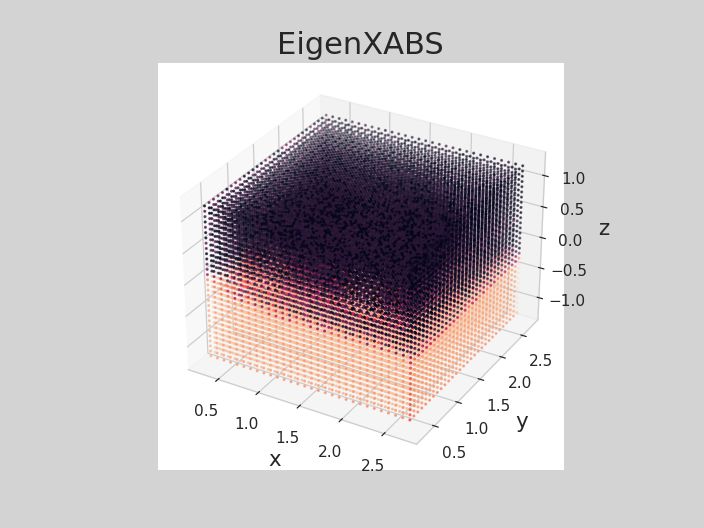

<IPython.core.display.Javascript object>


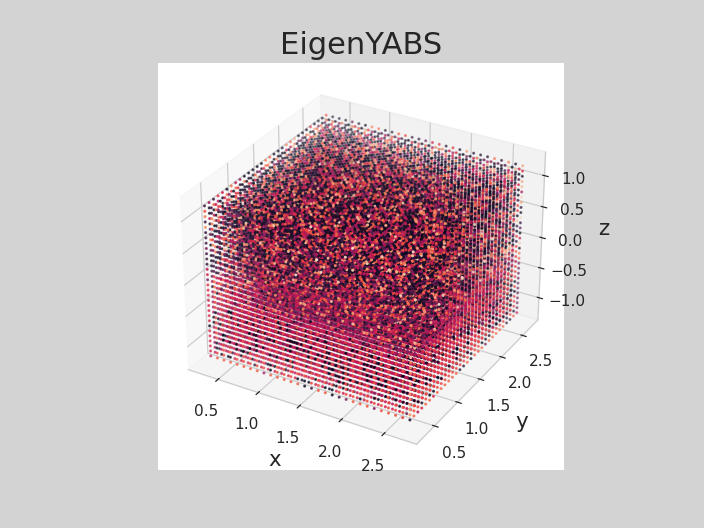

/tmp/ipykernel_5944/157988568.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure("EigenZABS", facecolor = 'lightgray')


<IPython.core.display.Javascript object>


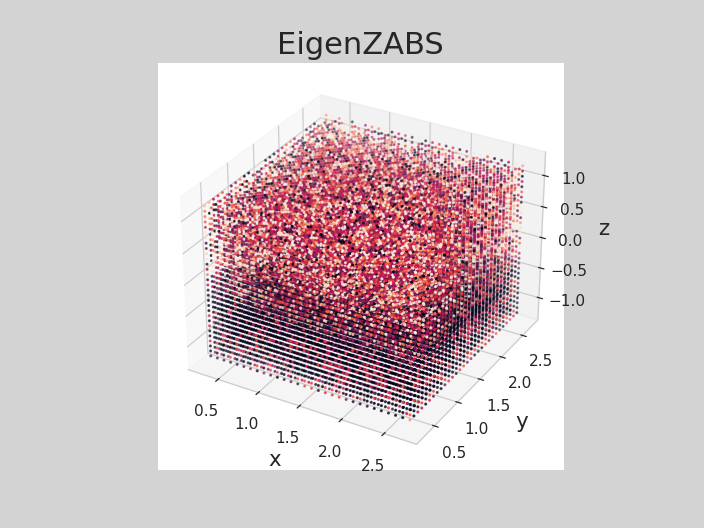

In [112]:
plt.figure("EigenXABS", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('EigenXABS', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)
ax3d.scatter(x_Inter, y_Inter, z_Inter, c = LastEigenvectorABS[:, 0], s = 1)
plt.show()

plt.figure("EigenYABS", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('EigenYABS', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)
ax3d.scatter(x_Inter, y_Inter, z_Inter, c = LastEigenvectorABS[:, 1], s = 1)
plt.show()

plt.figure("EigenZABS", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('EigenZABS', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)
ax3d.scatter(x_Inter, y_Inter, z_Inter, c = LastEigenvectorABS[:, 2], s = 1)
plt.show()

<IPython.core.display.Javascript object>


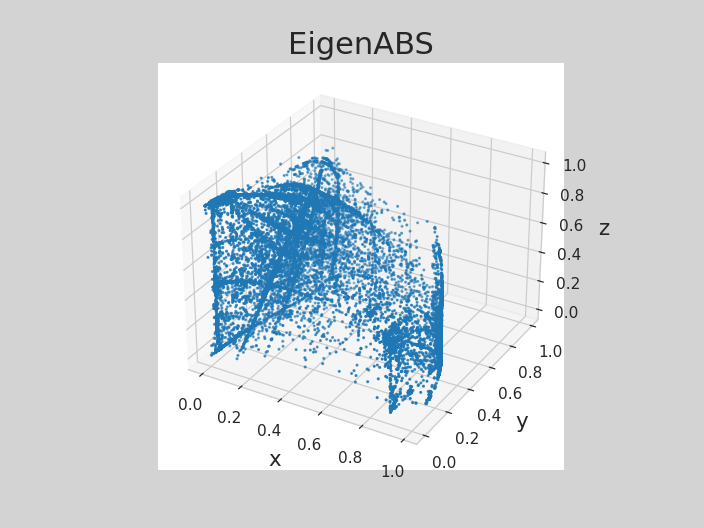

In [113]:
%matplotlib notebook
plt.figure("EigenABS", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('EigenABS', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)
ax3d.scatter(LastEigenvectorABS[:, 0], LastEigenvectorABS[:, 1], \
             LastEigenvectorABS[:, 2], s = 1)
plt.show()

In [114]:
from pylab import *
import operator
import random

df_full = pd.read_csv("Ev.csv")
columns = list(df_full.columns)
features = columns[:len(columns)]
df = df_full[features]

num_attr = len(df.columns)

k = 2

MAX_ITER = 50
n = len(df) 
m = 3.00
print(features)
print(df)
print(num_attr)
print(n)


['Ev_x', 'Ev_y', 'Ev_z']
           Ev_x      Ev_y          Ev_z
0      0.834734  0.493427  1.242024e-01
1      0.851300  0.524679  2.792935e-02
2      0.851490  0.524371  8.673783e-12
3      0.851044  0.525095  5.250802e-01
4      0.850970  0.525214  4.310100e-03
...         ...       ...           ...
26995  0.037341  0.859531  4.737623e-02
26996  0.036891  0.821203  4.712809e-01
26997  0.002942  0.082894  2.941900e-03
26998  0.036388  0.546589  3.940480e-01
26999  0.046291  0.817699  8.176989e-01

[27000 rows x 3 columns]
3
27000


<IPython.core.display.Javascript object>


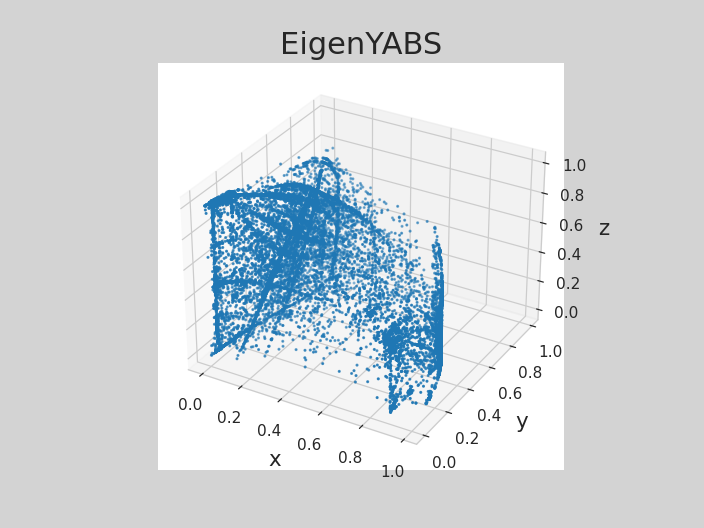

[[0.009730893823244754, 0.9902691061767552], [0.017379561188445483, 0.9826204388115545], [0.02109560087280691, 0.9789043991271931], [0.2397520977273401, 0.7602479022726599], [0.020637783206979794, 0.9793622167930202], [0.02129869273737342, 0.9787013072626267], [0.3405305182353686, 0.6594694817646314], [0.02148343389132664, 0.9785165661086733], [0.2407723780469781, 0.759227621953022], [0.021178427742917942, 0.9788215722570821], [0.0205391940058699, 0.9794608059941301], [0.02019002486525488, 0.979809975134745], [0.01802590689128667, 0.9819740931087133], [0.017501933409512217, 0.9824980665904879], [0.19760726614972796, 0.8023927338502721], [0.04013214632646393, 0.9598678536735361], [0.7725613445105182, 0.22743865548948183], [0.8465149762705128, 0.15348502372948725], [0.5989886791849912, 0.4010113208150088], [0.9140566480799832, 0.08594335192001684], [0.9244597760352574, 0.07554022396474266], [0.7991491698102273, 0.20085083018977273], [0.6649392472734397, 0.33506075272656044], [0.920491199

In [115]:
%matplotlib notebook
plt.figure("EigenYABS", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('EigenYABS', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)
ax3d.scatter(LastEigenvectorABS[:, 0], LastEigenvectorABS[:, 1], \
             LastEigenvectorABS[:, 2], s = 1)
plt.show()

def initializeMembershipMatrix():
    membership_mat = list()
    for i in range(n):
        random_num_list = [random.random() for i in range(k)]
        summation = sum(random_num_list)
        temp_list = [x / summation for x in random_num_list] 
        membership_mat.append(temp_list)
    return membership_mat

def calculateClusterCenter(membership_mat):
    cluster_mem_val = zip(*membership_mat)
    cluster_centers = list()
    cluster_mem_val_list = list(cluster_mem_val)
    for j in range(k):
        x = cluster_mem_val_list[j]
        xraised = [e ** m for e in x]
        denominator = sum(xraised)
        temp_num = list()
        for i in range(n):
            data_point = list(df.iloc[i])
            prod = [xraised[i] * val for val in data_point]
            temp_num.append(prod)
        numerator = map(sum, zip(*temp_num))
        center = [z / denominator for z in numerator]  
        cluster_centers.append(center)
    return cluster_centers

def updateMembershipValue(membership_mat, cluster_centers):
    data = []
    for i in range(n):
        x = list(df.iloc[i])
        data.append(x)
        distances = [np.linalg.norm(list(map(operator.sub, x, cluster_centers[j]))) for j in range(k)]
        for j in range(k):
            den = sum([math.pow(float(distances[j] / distances[c]), 2) for c in range(k)])
            membership_mat[i][j] = float(1 / den)
    return membership_mat, data

def getClusters(membership_mat):
    cluster_labels = list()
    for i in range(n):
        max_val, idx = max((val, idx) for (idx, val) in enumerate(membership_mat[i]))
        cluster_labels.append(idx)
    return cluster_labels

def fuzzyCMeansClustering():
    
    membership_mat = initializeMembershipMatrix()
    curr = 0
    while curr <= MAX_ITER:  
        cluster_centers = calculateClusterCenter(membership_mat)
        membership_mat, data = updateMembershipValue(membership_mat, cluster_centers)
        cluster_labels = getClusters(membership_mat)
        curr += 1
    print(membership_mat)
    return cluster_labels, cluster_centers, data, membership_mat


def xie_beni(membership_mat, center, data):
    sum_cluster_distance = 0
    min_cluster_center_distance = inf
    for i in range(k):
        for j in range(n):
            sum_cluster_distance = sum_cluster_distance + membership_mat[j][i] ** 2 * sum(
                power(data[j, :] - center[i, :], 2))  
    for i in range(k - 1):
        for j in range(i + 1, k):
            cluster_center_distance = sum(power(center[i, :] - center[j, :], 2))  # 计算类间距离
            if cluster_center_distance < min_cluster_center_distance:
                min_cluster_center_distance = cluster_center_distance
    return sum_cluster_distance / (n * min_cluster_center_distance)


labels, centers, data, membership = fuzzyCMeansClustering()
# print(labels)
# print(centers)
center_array = array(centers)
label = array(labels)
datas = array(data)


<IPython.core.display.Javascript object>


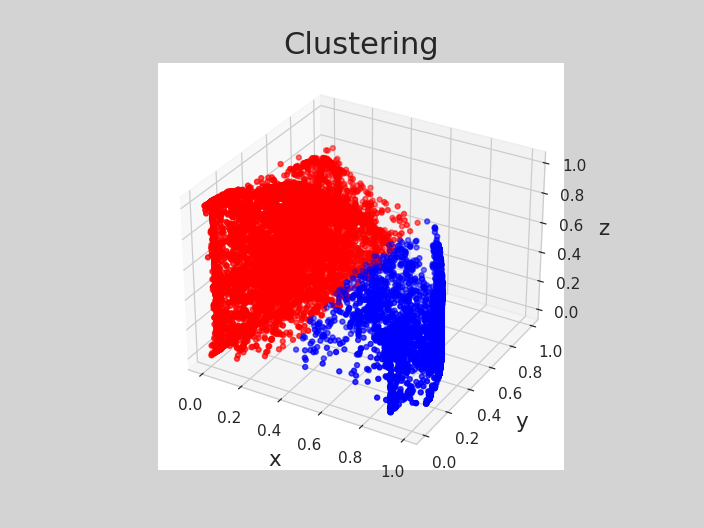

In [116]:
%matplotlib notebook
plt.figure("Clustering", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('Clustering', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)
ax3d.scatter(datas[nonzero(label == 0), 0], \
             datas[nonzero(label == 0), 1], datas[nonzero(label == 0), 2], \
             marker='o', color='r', label='0', s=10)
ax3d.scatter(datas[nonzero(label == 1), 0], \
             datas[nonzero(label == 1), 1], datas[nonzero(label == 1), 2], \
             marker='o', color='b', label='1', s=10)

plt.scatter(center_array[:, 0], center_array[:, 1], marker='x', color='m', s=30)
plt.show()

<IPython.core.display.Javascript object>


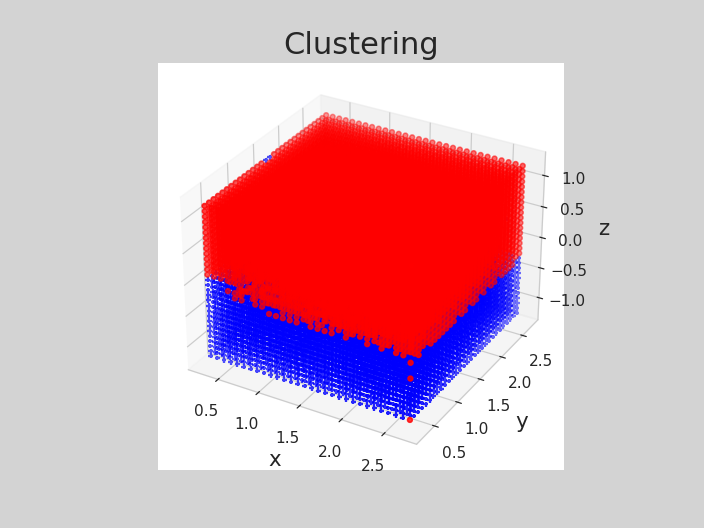

In [117]:
%matplotlib notebook
plt.figure("Clustering", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('Clustering', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)
ax3d.scatter(x_Inter[nonzero(label == 0)], y_Inter[nonzero(label == 0)],\
            z_Inter[nonzero(label == 0)], marker='o', color='r', \
            label='0', s=10)
ax3d.scatter(x_Inter[nonzero(label == 1)], y_Inter[nonzero(label == 1)], \
            z_Inter[nonzero(label == 1)], marker='+', color='b', \
            label='1', s=10)

plt.show()

<IPython.core.display.Javascript object>


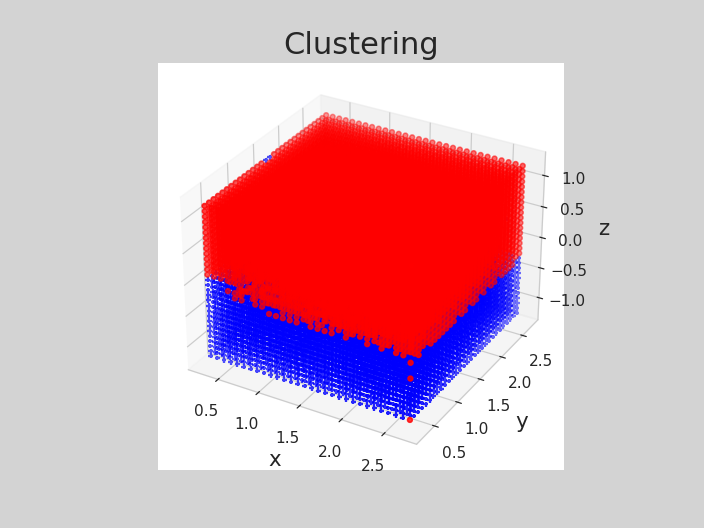

In [118]:
%matplotlib notebook
plt.figure("Clustering", facecolor = 'lightgray')
ax3d = plt.subplot(projection = '3d')
plt.title('Clustering', fontsize=20)
ax3d.set_xlabel('x', fontsize=14)
ax3d.set_ylabel('y', fontsize=14)
ax3d.set_zlabel('z', fontsize=14)
plt.tick_params(labelsize=10)
ax3d.scatter(x_Inter[label == 0], y_Inter[label == 0],\
            z_Inter[label == 0], marker='o', color='r', \
            label='0', s=10)
ax3d.scatter(x_Inter[label == 1], y_Inter[label == 1], \
            z_Inter[label == 1], marker='+', color='b', \
            label='1', s=10)

plt.show()

In [119]:
import copy
RegionA_dev_x = copy.deepcopy(Gauij_dev_x[nonzero(label == 0)])
RegionA_dev_y = copy.deepcopy(Gauij_dev_y[nonzero(label == 0)])
RegionA_dev_z = copy.deepcopy(Gauij_dev_z[nonzero(label == 0)])

RegionB_dev_x = copy.deepcopy(Gauij_dev_x[nonzero(label == 1)])
RegionB_dev_y = copy.deepcopy(Gauij_dev_y[nonzero(label == 1)])
RegionB_dev_z = copy.deepcopy(Gauij_dev_z[nonzero(label == 1)])

In [120]:
RegionA_len = len(RegionA_dev_x)
RegionB_len = len(RegionB_dev_x)
print(RegionA_len, RegionB_len)

Sum_RegionA = np.zeros((3, 3))
Sum_RegionB = np.zeros((3, 3))

for i in range(RegionA_len):

    pFpi_RegionA = np.vstack((RegionA_dev_x[i], RegionA_dev_y[i], \
                              RegionA_dev_z[i]))
    WW_RegionA = np.dot(pFpi_RegionA, pFpi_RegionA.transpose())
    Sum_RegionA = Sum_RegionA + WW_RegionA
Eigenvalues_RegionA, Eigenvectors_RegionA = np.linalg.eig(Sum_RegionA)
EigneValue_MaxIndex_RegionA = Eigenvalues_RegionA.argmax()
vesSwitch_RegionA = Eigenvectors_RegionA[EigneValue_MaxIndex_RegionA, :]
Coord_RegionA = abs(vesSwitch_RegionA)
    
for i in range(RegionB_len):

    pFpi_RegionB = np.vstack((RegionB_dev_x[i], RegionB_dev_y[i], \
                              RegionB_dev_z[i]))
    WW_RegionB = np.dot(pFpi_RegionB, pFpi_RegionB.transpose())
    Sum_RegionB = Sum_RegionB + WW_RegionB

Eigenvalues_RegionB, Eigenvectors_RegionB = np.linalg.eig(Sum_RegionB)
EigneValue_MaxIndex_RegionB = Eigenvalues_RegionB.argmax()
vesSwitch_RegionB = Eigenvectors_RegionB[EigneValue_MaxIndex_RegionB, :]
Coord_RegionB = abs(vesSwitch_RegionB)


15120 11880


In [122]:
print(Coord_RegionA, Coord_RegionB)


[0.02238791 0.89232885 0.45083036] [0.89372814 0.44628816 0.04557291]
